<a href="https://colab.research.google.com/github/TeaWithLucas/MLBirds/blob/main/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
!pip install opencv
import cv2
import numpy as np
import re
import seaborn as sns
import operator
import math
import random
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    from imageio import imread, imwrite
from PIL import Image
import tqdm.notebook as tq #just to provide visual feedback

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [76]:
#using pretrained EfficientNetB7 model
!pip install tensorflow
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [77]:
git_fldr = 'MLBirds/'
%cd C:\GIT

if os.path.exists(git_fldr):
  %cd MLBirds
  !git pull
else:
  !git clone https://github.com/TeaWithLucas/MLBirds.git
  %cd MLBirds

import data_load as data

C:\GIT
C:\GIT\MLBirds
Already up to date.


# Devices Info

In [78]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12729519045362977176
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15571718900438752773
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


# Data functions

In [79]:

#image_size = 224 #EfficientNetB0
#image_size = 300 #EfficientNetB3
image_size = 456 #EfficientNetB5

img_fldr='images/'
process_fldr='processed/' + str(image_size) + '/'

bound_fldr = process_fldr + 'bound/'
noise_fldr = process_fldr + 'noise/'
gamma_fldr = process_fldr + 'gamma/'
transpose_fldr = process_fldr + 'transpose/'
equalhist_fldr =  process_fldr + 'equalhist/'


def get_image_path(image_id, fldr=img_fldr):
  rows = data.images.loc[data.images.image_id == image_id]
  return os.path.join(fldr,rows.image_name.values[0])
  
def get_image(image_id, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return Image.open(path)

def get_cv2_image(image_id, flags=None, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return cv2.imread(path,flags)

def get_image_class_id(image_id):
  rows = data.image_class_labels.loc[data.image_class_labels.image_id == image_id]
  return rows.class_id.values[0]

def get_class_name(class_id):
  rows = data.classes.loc[data.classes.class_id == class_id]
  return rows.class_name.values[0]

def get_image_class_name(image_id):
  return get_class_name(get_image_class_id(test_id))

def get_bounding_box(image_id):
  rows = data.bounding_boxes.loc[data.bounding_boxes.image_id == image_id]
  return rows

def check_create_image_loc(path):
    if not os.path.exists(path):
      if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
      return True
    else:
      return False

#Visualization picture
def plt_img(img):
    img=np.array(img)
    plt.imshow(img)
    plt.show()

#Visualization picture
def plt_cv2_img(img):
    img=np.array(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def plot_grid_imgs(img_ids, fldrs=[img_fldr],samples=25):
  plt.figure(figsize=(10,10))
  rows = len(fldrs)
  cols = math.floor(samples/rows)
  for i, img_id in enumerate(random.choices(img_ids, k=cols)):
    for j, fldr in enumerate(fldrs):
      if rows==1:
        plt.subplot(5,samples/5,i+j+1)
      else:
        cell = (i)*cols+(j+1)
        plt.subplot(rows,cols,cell)
      plt.imshow(get_image(img_id,fldr))
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(get_class_name(get_image_class_id(img_id)))

# imported testing data

       image_id                                         image_name
0             1  001.Black_footed_Albatross/Black_Footed_Albatr...
1             2  001.Black_footed_Albatross/Black_Footed_Albatr...
2             3  001.Black_footed_Albatross/Black_Footed_Albatr...
3             4  001.Black_footed_Albatross/Black_Footed_Albatr...
4             5  001.Black_footed_Albatross/Black_Footed_Albatr...
...         ...                                                ...
11783     11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784     11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785     11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786     11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787     11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
     class_id              class_name
0           1  Black_footed_Albatross
1           2        Laysan_Albatross
2           3         Sooty_Albatross
3           4     

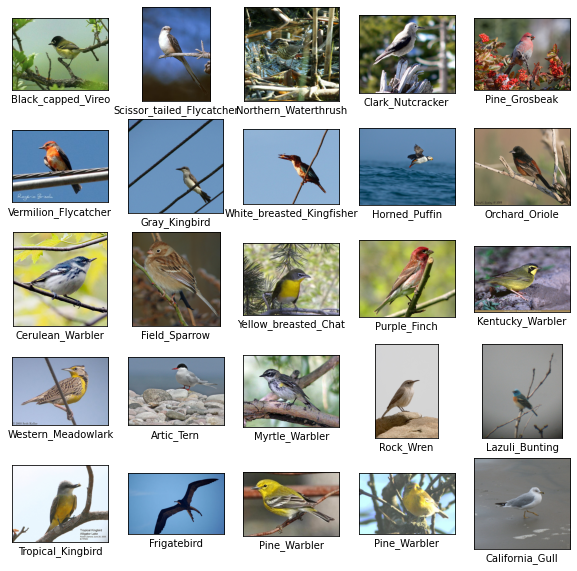

In [80]:
#testing imported data
print(data.images)
print(data.classes)
print(data.image_class_labels)
print(data.bounding_boxes)
print(data.train_test_split)
plot_grid_imgs(data.images.image_id)


# Data processing

In [81]:
heights = []
widths = []

for img_id in tq.tqdm(data.images.image_id):
  img = get_cv2_image(img_id)
  height, width, channels = img.shape
  heights.append(height)
  widths.append(height)

In [82]:
# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)

print(min(heights))
print(min(widths))
print(Average(heights))
print(Average(widths))

120
120
386.02994570749917
386.02994570749917


In [83]:
def bound_image(img_id):
    img = get_cv2_image(img_id)
    bounding_box = get_bounding_box(img_id)
    #print(img_id,bounding_box)
    x = bounding_box.x.values[0]
    y = bounding_box.y.values[0]
    w = bounding_box.width.values[0]
    h = bounding_box.height.values[0]
    max_dim = max(w, h)
    w_diff = math.floor((w - max_dim)/2)
    h_diff = math.floor((h - max_dim)/2)
    x_srt = x+w_diff
    x_end = x+max_dim
    y_srt = y+h_diff
    y_end = y+max_dim
    if x_srt < 0:
      x_srt = x_srt - x_srt
      x_end = x_end - x_srt
    if y_srt < 0:
      y_srt = x_srt - x_srt
      y_end = x_end - x_srt
    #print(x_srt,x_end,y_srt,y_end)
    crop_img = img[y_srt:y_end,x_srt:x_end] #crops the image with respect to bounding boxes mentioned in the dataset
    return crop_img

def bound_images(image_ids, image_size):
    for img_id in tq.tqdm(image_ids):
        new_path = get_image_path(img_id,bound_fldr)
        #check if already processed
        if check_create_image_loc(new_path):
          cur_img = bound_image(img_id)
          height, width, channels = cur_img.shape
          #max_dim = max(height, width)
          #width_new = math.floor(image_size/max_dim * width)
          #height_new = math.floor(image_size/max_dim * height)
          #print(width_new, height_new)
          resize_img = cv2.resize(cur_img, (image_size, image_size)) #resizing the cropped image so that all images have same dimensions and can easily be converted to np array 
          #also reduces the memory usage
          #took the average of all images to rezise (mean of x+width, y+height)
          #save picture to a new path
          cv2.imwrite(new_path ,resize_img)


bound_images(data.images.image_id, image_size)

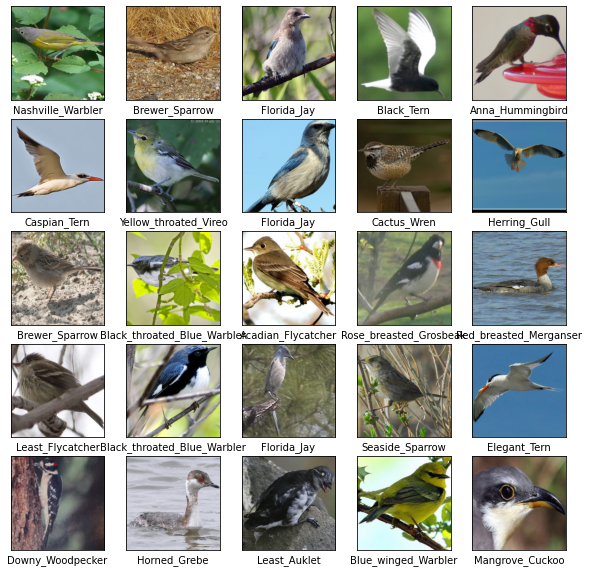

In [84]:
plot_grid_imgs(data.images.image_id, [bound_fldr])

# preprocessing

In [85]:
#Add random noise (actually, randomly change the gray value of pixels on the image to 255, which is white)
def random_noise(img_id,noise_num):
    img = get_cv2_image(img_id,fldr=bound_fldr)
    img_noise = img
    rows, cols, chn = img_noise.shape
    for i in range(noise_num):
        x = np.random.randint(0, rows)
        y = np.random.randint(0, cols)
        img_noise[x, y, :] = 255
    return img_noise

def gamma_transform(img_id):
    img = get_cv2_image(img_id,flags=0,fldr=bound_fldr)
    fi = img / 255.0
    gamma = 0.4
    out_img = np.power(fi, gamma)
    return out_img

def pic_transpose(img_id):
    img = get_image(img_id,fldr=bound_fldr)
    #transpose_img = img.transpose(Image.ROTATE_90)
    transpose_img = img.transpose(Image.ROTATE_180)
    #transpose_img = img.transpose(Image.ROTATE_270)
    return transpose_img

def get_imghist(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img],[0],None,[256],[0,255])
    return hist

def cal_equalhist(img_id):
    img=get_cv2_image(img_id,fldr=bound_fldr)
    if len(img.shape) == 3:
         img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    h,w = img.shape[:2]
    grathist = get_imghist(img)
 
    zerosumMoment = np.zeros([256],np.uint32)
    for p in range(256):
        if p ==0:
            zerosumMoment[p] = grathist[0]
        else:
            zerosumMoment[p] = zerosumMoment[p-1] +grathist[p]
 
    output_q = np.zeros([256],np.uint8)
    cofficient = 256.0/(h*w)
    for p in range(256):
        q = cofficient *float(zerosumMoment[p]) - 1
        if q >= 0:
            output_q[p] = math.floor(q)
        else:
            output_q[p] = 0
 
    equalhistimage = np.zeros(img.shape,np.uint8)
    for i in range(h):
        for j in range(w):
            equalhistimage[i][j] = output_q[img[i][j]]
    return equalhistimage

#bound_fldr = process_fldr + 'bound/'
#noise_fldr = process_fldr + 'noise/'
#gamma_fldr = process_fldr + 'gamma/'
#transpose_fldr = process_fldr + 'transpose/'
#equalhist_fldr =  process_fldr + 'equalhist/'


def preprocess_images(image_ids):
  for img_id in tq.tqdm(image_ids):
    noise_path = get_image_path(img_id,noise_fldr)
    if check_create_image_loc(noise_path):
      noise_img = random_noise(img_id,3000)
      cv2.imwrite(noise_path, noise_img)
    
    gamma_path = get_image_path(img_id,gamma_fldr)
    if check_create_image_loc(gamma_path):
      gamma_img = gamma_transform(img_id)
      cv2.imwrite(gamma_path,gamma_img)
    
    transpose_path = get_image_path(img_id,transpose_fldr)
    if check_create_image_loc(transpose_path):
      transpose_img = pic_transpose(img_id)
      transpose_img.save(transpose_path)

    equalhist_path = get_image_path(img_id,equalhist_fldr)
    if check_create_image_loc(equalhist_path):
      equalhist_img = cal_equalhist(img_id)
      cv2.imwrite(equalhist_path,equalhist_img)

#not implemented atm
#preprocess_images(data.images.image_id)

In [86]:

#plot_grid_imgs(data.images.image_id, [bound_fldr, noise_fldr, gamma_fldr, transpose_fldr, equalhist_fldr])

# datasets

In [87]:
img1 = get_cv2_image(1, fldr=bound_fldr)
img2 = get_cv2_image(1, fldr=gamma_fldr)
img3 = np.concatenate([img1, img2], axis=2)
print(np.shape(img1))
print(np.shape(img2))
print(np.shape(img3))

(456, 456, 3)
(456, 456, 3)
(456, 456, 6)


In [88]:
#seperting testing and training data as given in the dataset
train_ids =[]
x_train_list =[]
y_train_list =[]
temp_ids =[]
x_temp_list =[]
y_temp_list=[]

#bound_fldr = process_fldr + 'bound/'
#noise_fldr = process_fldr + 'noise/'
#gamma_fldr = process_fldr + 'gamma/'
#transpose_fldr = process_fldr + 'transpose/'
#equalhist_fldr =  process_fldr + 'equalhist/'



for row in tq.tqdm(data.train_test_split.itertuples(),total=len(data.train_test_split)):
  img_id = row.image_id
  bound_img = get_image(img_id, fldr=bound_fldr)
  #noise_img = get_cv2_image(img_id, fldr=noise_fldr)
  #gamma_img = get_cv2_image(img_id, fldr=gamma_fldr)
  #transpose_img = get_cv2_image(img_id, fldr=transpose_fldr)
  #equalhist_img = get_cv2_image(img_id, fldr=equalhist_fldr)

  img_channels = np.concatenate([bound_img], axis=2)
  y = get_image_class_id(img_id) -1 #to make the values start from 0 so that total values will be 200 when converting to catogerical
  if(row.is_training_image==0):
    train_ids.append(img_id)
    x_train_list.append(img_channels)
    y_train_list.append(y) 
  else:
    temp_ids.append(img_id)
    x_temp_list.append(img_channels)
    y_temp_list.append(y)

#creating 50/50% test set and developlement set from x_temp_list, y_temp_list
x_test_list,x_dev_list,y_test_list,y_dev_list = train_test_split(x_temp_list,y_temp_list, train_size = 0.5, random_state = 1)
x_temp_list = None
y_temp_list = None

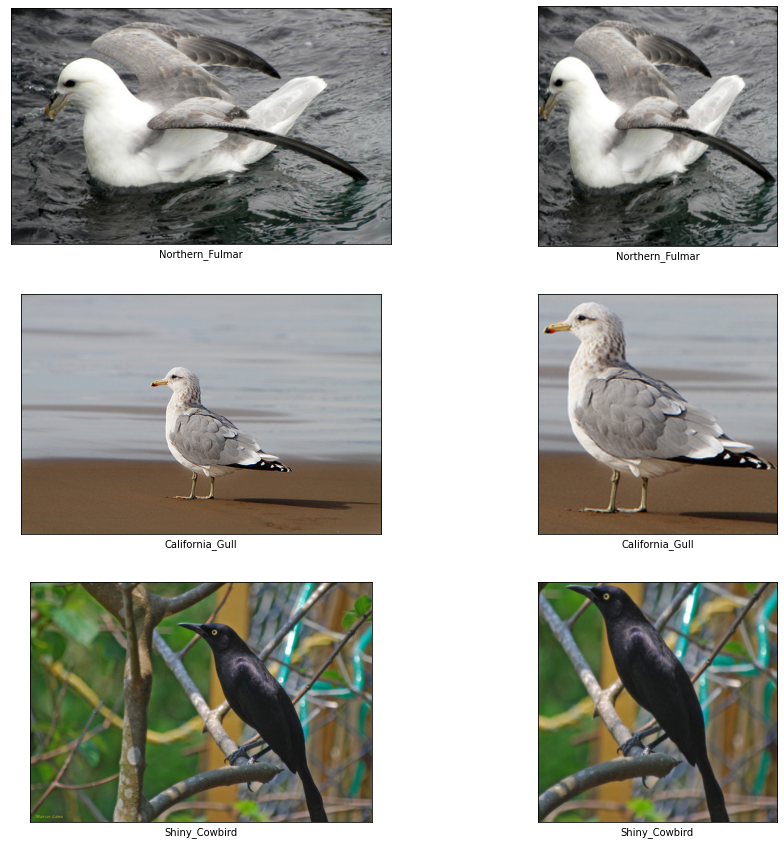

In [89]:
samples = 3
plt.figure(figsize=(15,15))
random_samples = random.choices(range(len(train_ids)),k=samples)
for i in range(samples):
  smple = random_samples[i]
  img_id = train_ids[smple]
  plt.subplot(samples,2,i*2+1)
  plt.imshow(get_image(img_id))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  # The CIFAR labels happen to be arrays, 
  # which is why you need the extra index
  plt.xlabel(get_class_name(get_image_class_id(img_id)))
  plt.subplot(samples,2,i*2+2)
  plt.imshow(x_train_list[smple])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  # The CIFAR labels happen to be arrays, 
  # which is why you need the extra index
  plt.xlabel(get_class_name(get_image_class_id(img_id)))

In [90]:
x_train = np.array(x_train_list)#converting the images to np array
x_train_list = None
x_test = np.array(x_test_list)#converting the images to np array
x_test_list = None
x_dev = np.array(x_dev_list)#converting the images to np array
x_dev_list = None

In [91]:
y_train = to_categorical(y_train_list) #converting the class_id vectors to matrix form
y_test = to_categorical(y_test_list) #converting the class_id vectors to matrix form
y_dev = to_categorical(y_dev_list) #converting the class_id vectors to matrix form

# Implimentation

In [92]:
def create_checkpoint(name):
  path = name + '_best_model.hdf5'
  return ModelCheckpoint(filepath=path,
                              monitor='val_loss',
                              verbose=2, 
                              save_best_only=True,
                              mode='min')

def build_model(num_classes, img_size, name, img_augmentation,net,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = img_augmentation(inputs)
    #EfficientNetB0 	224
    #EfficientNetB1 	240
    #EfficientNetB2 	260
    #EfficientNetB3 	300
    #EfficientNetB4 	380
    #EfficientNetB5 	456
    #EfficientNetB6 	528
    #EfficientNetB7 	600
    
    model = net(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=name + "_EfficientNet3")
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def unfreeze_model(model,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
def plot_hist(hist):
  val_accuracy = hist.history['val_accuracy']
  accuracy = hist.history['accuracy']

  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label = 'val_accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(["Train", "Balidation"], loc="upper left")

def model_acc(model):
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  print(test_acc)

Epoch 1/10
58/58 [==============================] - 170s 3s/step - loss: 3.8377 - accuracy: 0.4978 - val_loss: 1.6892 - val_accuracy: 0.6149
Epoch 2/10
58/58 [==============================] - 155s 3s/step - loss: 1.1490 - accuracy: 0.8007 - val_loss: 1.3047 - val_accuracy: 0.6760
Epoch 3/10
58/58 [==============================] - 158s 3s/step - loss: 0.5697 - accuracy: 0.8800 - val_loss: 1.1376 - val_accuracy: 0.7054
Epoch 4/10
58/58 [==============================] - 155s 3s/step - loss: 0.3678 - accuracy: 0.9132 - val_loss: 1.1000 - val_accuracy: 0.7351
Epoch 5/10
58/58 [==============================] - 161s 3s/step - loss: 0.2957 - accuracy: 0.9263 - val_loss: 1.2944 - val_accuracy: 0.7314
Epoch 6/10
58/58 [==============================] - 167s 3s/step - loss: 0.2807 - accuracy: 0.9355 - val_loss: 1.3155 - val_accuracy: 0.7484
Epoch 7/10
58/58 [==============================] - 152s 3s/step - loss: 0.2405 - accuracy: 0.9396 - val_loss: 1.4943 - val_accuracy: 0.7471
Epoch 8/10
58

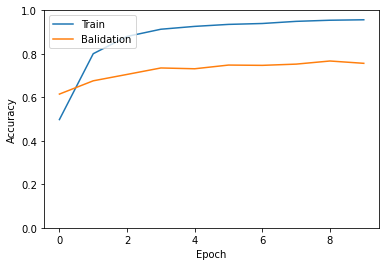

In [93]:
img_augmentation_a = Sequential(
    [
        #preprocessing.RandomRotation(factor=0.15),
        #preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        #preprocessing.RandomFlip(),
        #preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

model_B5_a =  build_model(y_dev.shape[1],image_size,'model_B5_a',img_augmentation_a,keras.applications.EfficientNetB5,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

history_B5_a = model_B5_a.fit(x_train,y_train, batch_size=100, epochs=10, validation_data=(x_dev,y_dev))

plot_hist(history_B5_a)
model_acc(model_B5_a)


Epoch 1/10
58/58 [==============================] - 177s 3s/step - loss: 0.0781 - accuracy: 0.9789 - val_loss: 1.5344 - val_accuracy: 0.7861
Epoch 2/10
58/58 [==============================] - 161s 3s/step - loss: 0.0449 - accuracy: 0.9893 - val_loss: 1.5289 - val_accuracy: 0.7988
Epoch 3/10
58/58 [==============================] - 165s 3s/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 1.5729 - val_accuracy: 0.7938
Epoch 4/10
58/58 [==============================] - 158s 3s/step - loss: 0.0284 - accuracy: 0.9921 - val_loss: 1.5648 - val_accuracy: 0.7988
Epoch 5/10
58/58 [==============================] - 177s 3s/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 1.4816 - val_accuracy: 0.8045
Epoch 6/10
58/58 [==============================] - 166s 3s/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 1.4793 - val_accuracy: 0.8005
Epoch 7/10
58/58 [==============================] - 161s 3s/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 1.4814 - val_accuracy: 0.8058
Epoch 8/10
58

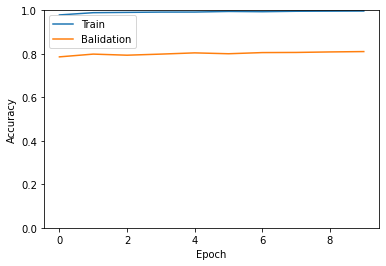

In [94]:
unfreeze_model(model_B5_a,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

history_B5_a = model_B5_a.fit(x_train,y_train, batch_size=100, epochs=10, validation_data=(x_dev,y_dev))

plot_hist(history_B5_a)
model_acc(model_B5_a)


In [95]:
# use a classifier model to predict the values of a given set of test data
# and a feature filter class 
def predict_svm_classifier(svm_clf, x, sentanalysis):
  x_reduced = reduce_sentanalysis(sentanalysis,x)
  return svm_clf.predict(x_reduced) 


In [96]:
import sklearn.metrics

test_loss, test_acc = model_B5_a.evaluate(x_test, y_test, verbose=2)
print(test_loss, test_acc)

94/94 - 51s - loss: 1.6713 - accuracy: 0.7998
1.671298861503601 0.7997997999191284


In [97]:
dev_pred = np.argmax(model_B5_a.predict(x_dev), axis=-1)
print("\nDev set classification report")
print(sklearn.metrics.classification_report(y_dev_list,dev_pred))


Dev set classification report
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        17
           1       0.82      1.00      0.90        14
           2       0.82      0.69      0.75        13
           3       0.94      0.88      0.91        17
           4       1.00      1.00      1.00        14
           5       0.92      1.00      0.96        12
           6       1.00      1.00      1.00        17
           7       1.00      0.95      0.97        20
           8       0.53      0.64      0.58        14
           9       1.00      1.00      1.00        13
          10       0.71      0.71      0.71        17
          11       0.94      0.94      0.94        16
          12       1.00      0.92      0.96        12
          13       0.87      0.93      0.90        14
          14       0.89      0.84      0.86        19
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00       

In [98]:
test_pred = np.argmax(model_B5_a.predict(x_test), axis=-1)
print("\nTest set classification report")
print(sklearn.metrics.classification_report(y_test_list, test_pred))


Test set classification report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.75      0.94      0.83        16
           2       1.00      0.65      0.79        17
           3       1.00      1.00      1.00        13
           4       1.00      0.88      0.93        16
           5       1.00      0.94      0.97        18
           6       0.93      1.00      0.96        13
           7       0.88      0.70      0.78        10
           8       0.75      0.75      0.75        16
           9       0.94      1.00      0.97        17
          10       0.71      0.77      0.74        13
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        18
          13       0.88      0.94      0.91        16
          14       0.92      1.00      0.96        11
          15       0.95      0.90      0.92        20
          16       1.00      0.80      0.89      

tf.Tensor(
[[12  0  2 ...  0  0  0]
 [ 0 14  0 ...  0  0  0]
 [ 0  1  9 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 17]], shape=(200, 200), dtype=int32)
tf.Tensor(
[[12  1  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 1  2 11 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  1  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0 11]], shape=(200, 200), dtype=int32)


Text(0.5, 1.0, 'Test set confusion matrix')

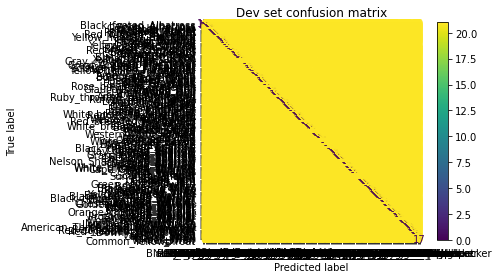

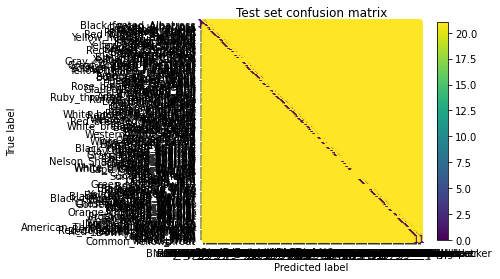

In [99]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model_B5_a, data.classes.class_name)

dev_cm = tf.math.confusion_matrix(y_dev_list,dev_pred)
print(dev_cm)

dev_cm_plt = sklearn.metrics.plot_confusion_matrix(classifier,x_dev,y_dev_list)
dev_cm_plt.ax_.set_title("Dev set confusion matrix")

test_cm =tf.math.confusion_matrix(y_test_list,test_pred)
print(test_cm)

test_cm_plt = sklearn.metrics.plot_confusion_matrix(classifier,x_test,y_test_list)
test_cm_plt.ax_.set_title("Test set confusion matrix")

